In [5]:
%pip install "git+https://github.com/MrG1raffe/signature.git"

  Cloning https://github.com/MrG1raffe/signature.git to /tmp/pip-req-build-0zjffjil
  Running command git clone --filter=blob:none --quiet https://github.com/MrG1raffe/signature.git /tmp/pip-req-build-0zjffjil
  Resolved https://github.com/MrG1raffe/signature.git to commit 613e9fcdf25e80bbd8de17ae86a91866792469f3
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [6]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import iisignature

from signature.tensor_algebra import TensorAlgebra
from signature.tensor_sequence import TensorSequence
from pricing.models.sig_vol import SigVol
from pricing.products.vanilla_option import VanillaOption
from pricing.models.model_params import LewisParams
from pricing.utility import from_delta_call_to_strike

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%%time

ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: user 2min 47s, sys: 276 ms, total: 2min 47s
Wall time: 2min 47s


## SigVol model

In [8]:
# define basic words

N = 5
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

In [10]:
rho = -0.8

vol_ts = 0.2 * Ø + 0.01 * _1 + 0.2 * _2 + 0.05 * _11 + 0.05 * _12 + 0.07 * _22 + 0.01 * _222 + \
    0.03 * _221 + 0.01 * _121 + 0.01 * _211 + 0.3 * _22222
model = SigVol(vol_ts=vol_ts, ta=ta, rho=rho)

In [11]:
ta.print(model.vol_ts)

0.2*∅ + 0.01*1 + 0.2*2 + 0.05*11 + 0.05*12 + 0.07*22 + 0.01*121 + 0.01*211 + 0.03*221 + 0.01*222 + 0.3*22222


Text(0.5, 1.0, 'Vol trajectories')

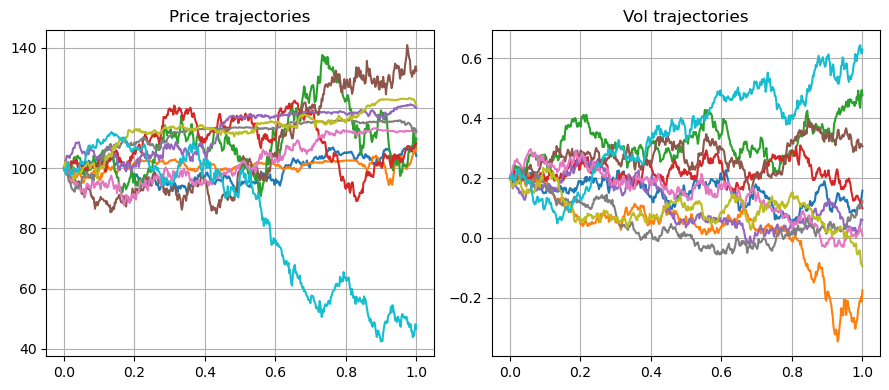

In [12]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")

### Pricing time

In [13]:
K = from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.22, ttm=T)
k = np.log(K / F0)

option = VanillaOption(T=T, K=K, flag="call")

In [17]:
%%time
smile_cf = option.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                            pricing_params=LewisParams(cf_timestep=0.01, N_points=25))

CPU times: user 25.8 s, sys: 47.7 ms, total: 25.8 s
Wall time: 3.6 s


[]

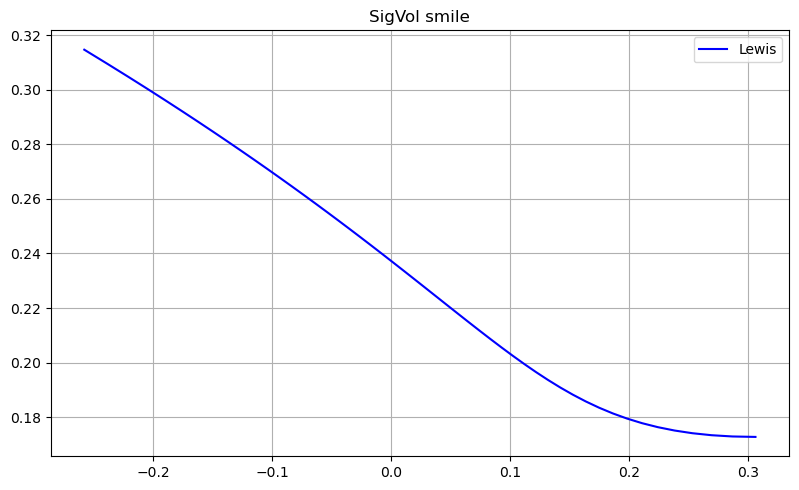

In [18]:
fig, ax = plt.subplots()

ax.plot(k, smile_cf, "b", label="Lewis")
ax.set_title("SigVol smile")
ax.legend()
plt.plot()

### Example of a volatility surface

CPU times: user 1min 11s, sys: 271 ms, total: 1min 11s
Wall time: 9.63 s


Text(0.5, 1.0, 'IV smiles in SigVol')

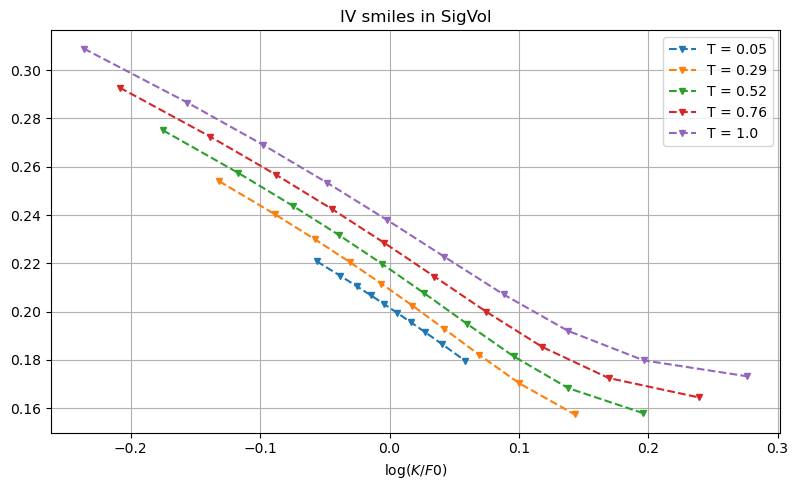

In [19]:
%%time


T_grid = np.linspace(0.05, 1, 5)
K_arr = np.array([from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 10), F0=F0, sigma=0.2, ttm=T) for T in T_grid])
option_call_surf = VanillaOption(T=T_grid, K=K_arr, flag="call")


prices_surf = option_call_surf.get_price(model=model, method="lewis", F0=F0, is_vol_surface=False, 
                                         pricing_params=LewisParams(cf_timestep=0.01, N_points=25))

fig, ax = plt.subplots()
option_call_surf.plot_smiles(option_prices_model=prices_surf, F0=100, ax=ax)
ax.set_title("IV smiles in SigVol")